<a href="https://colab.research.google.com/github/borundev/pytorch_examples/blob/kaggle-dataset/Kaggle_TB_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq --no-cache-dir --upgrade git+https://github.com/borundev/pytorch_examples@kaggle-dataset

In [2]:
from data.kaggle.tb_xrays import TBDataModule

In [5]:
kaggle_username=input('kaggle_username: ')
kaggle_key=input('kaggle_key: ')

KeyboardInterrupt: ignored

In [3]:
try:
  dm = TBDataModule(kaggle_username=kaggle_username, 
                  kaggle_key=kaggle_key,
                  )
except NameError:
  dm = TBDataModule()

dm.prepare_data()
dm.setup()

In [4]:
import torchvision
import matplotlib.pyplot as plt

tensor([1, 0, 0, 1])


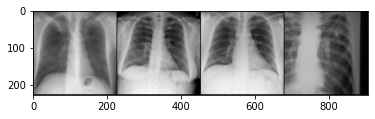

In [5]:
imgs,labels = next(iter(dm.train_dataloader()))
plt.imshow(torchvision.utils.make_grid(imgs[:16],normalize=True).permute(1,2,0))
print(labels)

In [6]:
import pytorch_lightning as pl

In [7]:
from pytorch_lightning.loggers import WandbLogger


In [8]:
class BoilerPlate(pl.LightningModule):


    @staticmethod
    def loss(inp, y):
        """
        Since pytorch doesn't have a one-hot version of cross entropy we implement it here
        :param inp:
        :param y:
        :return:
        """
        lsm = nn.LogSoftmax(1)
        yp = torch.stack([1 - y, y], 1)
        return -torch.mean(torch.sum(yp * lsm(inp), 1))

    def forward(self, x):
        return NotImplementedError()

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        _, preds = torch.max(outputs, 1)
        loss = self.loss(outputs, y)
        accuracy = (preds == y.data).type(torch.float32).mean()
        self.log('train/loss', loss)
        self.log('train/accuracy', accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        _, preds = torch.max(outputs, 1)
        loss = self.loss(outputs, y)
        accuracy=(preds == y.data).type(torch.float32).mean()
        self.log('val/loss', loss)
        self.log('val/accuracy', accuracy)
        return y,outputs

    def validation_epoch_end(self, outputs):

        ground_truths, predictions = zip(*outputs)
        predictions=torch.nn.Softmax(1)(torch.cat(predictions)).cpu().numpy()
        ground_truths=torch.cat(ground_truths).cpu().numpy().astype(np.int)

        self.log("pr", wandb.plot.pr_curve(ground_truths, predictions,
                                                labels=['Normal','Tuberculosis']))
        self.log("roc", wandb.plot.roc_curve(ground_truths, predictions,
                                                labels=['Normal','Tuberculosis']))
        self.log('confusion_matrix',wandb.plot.confusion_matrix(predictions,
                                    ground_truths,class_names=['Normal','Tuberculosis']))

    def test_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        _, preds = torch.max(outputs, 1)
        loss = self.loss(outputs, y)
        accuracy=(preds == y.data).type(torch.float32).mean()
        self.log('test/loss', loss)
        self.log('test/accuracy', accuracy)

    def configure_optimizers(self):
        NotImplementedError


In [9]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np

class CustomModel(BoilerPlate):

    def __init__(self):
        super().__init__()
        model_ft = models.resnet152(pretrained=True)
        for param in model_ft.parameters():
            param.requires_grad = False

        num_ftrs = model_ft.fc.in_features
        # Here the size of each output sample is set to 2.
        # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
        model_ft.fc = nn.Linear(num_ftrs, 2)
        self.model = model_ft

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.SGD(self.model.fc.parameters(), lr=0.001, momentum=0.9)
        return optimizer


In [ ]:
import wandb
wandb_logger = WandbLogger(project='TB Dataset Kaggle')
trainer = pl.Trainer(
        gpus=1,
        max_epochs=5,
        logger=wandb_logger,
        progress_bar_refresh_rate=50,
        )
model = CustomModel()
trainer.fit(model, dm)
wandb.finish()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: borundev (use `wandb login --relogin` to force relogin)



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 58.1 M
---------------------------------
4.1 K     Trainable params
58.1 M    Non-trainable params
58.1 M    Total params
